<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU_AE/GRU_AE_Cu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 1.50 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 20 09:23:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Cu'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 5.4 MB/s 
     |████████████████████████████████| 133 kB 53.6 MB/s 
     |████████████████████████████████| 97 kB 8.2 MB/s 
     |████████████████████████████████| 138 kB 54.9 MB/s 
     |████████████████████████████████| 170 kB 67.6 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 62 kB 971 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

     # layer 1
    model.add(GRU(units=128, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(GRU(units=64, return_sequences=False, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 3
    model.add(RepeatVector(window_len))
    # layer 4
    model.add(GRU(units=64, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 5
    model.add(GRU(units=128, return_sequences=False, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 6
    model.add((Dense(1)))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: 5hy42gua
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU_AE/sweeps/5hy42gua


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: ciynsjuf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/200
16/16 [==============================] - 27s 134ms/step - loss: 0.1466 - mean_squared_error: 0.1466 - mean_absolute_error: 0.2973 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0940
Epoch 2/200
16/16 [==============================] - 0s 22ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0729 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0595
Epoch 3/200
16/16 [==============================] - 0s 23ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0591 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0596
Epoch 4/200
16/16 [==============================] - 0s 24ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0539 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0585
Epoch 5/200
16/16 [==============================] - 0s 23ms/step - loss: 0.0049 - mean_square

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,147
loss,0.00147
mean_squared_error,0.00147
mean_absolute_error,0.02946
val_loss,0.00382
val_mean_squared_error,0.00382
val_mean_absolute_error,0.04985
_runtime,91
_timestamp,1626773223
_step,147
best_val_loss,0.0024


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▄▄▃▃▂▂▃▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▄▄▃▃▂▂▃▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▄▄▃▃▃▂▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▅▅▆▅▅▃▃▃▅▃▃▂▂▃▂▄▃▃▂▃▃▁▄▁▂▁▂▁▁▂▂▁▄▁▁▄
val_mean_squared_error,██▇▆▅▅▆▅▅▃▃▃▅▃▃▂▂▃▂▄▃▃▂▃▃▁▄▁▂▁▂▁▁▂▂▁▄▁▁▄
val_mean_absolute_error,██▆▅▅▆▇▆▅▃▃▃▆▃▃▂▂▂▂▅▄▃▂▂▃▁▅▁▁▁▂▁▁▂▃▁▅▂▁▅
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: dlkxebkz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 19s 368ms/step - loss: 0.1993 - mean_squared_error: 0.1993 - mean_absolute_error: 0.3598 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0906
Epoch 2/100
16/16 [==============================] - 4s 276ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0824 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0551
Epoch 3/100
16/16 [==============================] - 4s 265ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0727 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0571
Epoch 4/100
16/16 [==============================] - 4s 264ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0642 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0594
Epoch 5/100
16/16 [==============================] - 4s 273ms/step - loss: 0.0079 - mean_sq

epoch,35
loss,0.00221
mean_squared_error,0.00221
mean_absolute_error,0.03735
val_loss,0.00488
val_mean_squared_error,0.00488
val_mean_absolute_error,0.05375
_runtime,175
_timestamp,1626773425
_step,35
best_val_loss,0.00433


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▂▂▂█▂▃▂▂▃▃▁▂▇█▁▁▂▁▂█▁▂▂▁▁▁▁▂▁▂▃▁▃▃▁
val_mean_squared_error,▆▂▂▂█▂▃▂▂▃▃▁▂▇█▁▁▂▁▂█▁▂▂▁▁▁▁▂▁▂▃▁▃▃▁
val_mean_absolute_error,▇▂▂▃█▂▃▂▃▃▃▁▂▇█▁▂▃▂▂█▁▂▂▂▁▂▁▂▁▂▃▁▄▃▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2f7fpnxw with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 12s 531ms/step - loss: 0.1519 - mean_squared_error: 0.1519 - mean_absolute_error: 0.3119 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1351
Epoch 2/100
8/8 [==============================] - 2s 307ms/step - loss: 0.0270 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1360 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0553
Epoch 3/100
8/8 [==============================] - 2s 274ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0872 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0527
Epoch 4/100
8/8 [==============================] - 2s 283ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0714 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0621
Epoch 5/100
8/8 [==============================] - 2s 291ms/step - loss: 0.0092 - mean_squared_erro

epoch,59
loss,0.00205
mean_squared_error,0.00205
mean_absolute_error,0.03573
val_loss,0.00531
val_mean_squared_error,0.00531
val_mean_absolute_error,0.05877
_runtime,149
_timestamp,1626773586
_step,59
best_val_loss,0.00272


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▃▂▂▂▁▁▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▂▁▂▁▁▁▂▂▁▁
val_loss,█▂▂▅▃▅▅▂▁▂▁▃▁▂▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▂▁▁▁▂▁▂▁▁▂
val_mean_squared_error,█▂▂▅▃▅▅▂▁▂▁▃▁▂▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▂▁▁▁▂▁▂▁▁▂
val_mean_absolute_error,█▂▃▆▄▆▆▂▁▃▂▄▂▃▁▃▁▂▂▂▂▁▁▂▁▃▁▁▁▁▂▁▂▁▂▁▃▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: werx16ds with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 13s 429ms/step - loss: 0.1335 - mean_squared_error: 0.1335 - mean_absolute_error: 0.2815 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0782
Epoch 2/100
16/16 [==============================] - 4s 281ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.0976 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1009
Epoch 3/100
16/16 [==============================] - 5s 296ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0908 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0620
Epoch 4/100
16/16 [==============================] - 4s 282ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0779 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0583
Epoch 5/100
16/16 [==============================] - 5s 280ms/step - loss: 0.0112 - mean_sq

epoch,13
loss,0.00655
mean_squared_error,0.00655
mean_absolute_error,0.06159
val_loss,0.01225
val_mean_squared_error,0.01225
val_mean_absolute_error,0.09565
_runtime,75
_timestamp,1626773673
_step,13
best_val_loss,0.00593


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▂▂▂▂▁▁▂▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▂▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▂▁▁▁▁
val_loss,▃▆▁▁▅█▅▂▃▂▁▁▁▄
val_mean_squared_error,▃▆▁▁▅█▅▂▃▂▁▁▁▄
val_mean_absolute_error,▄▇▂▁▆█▅▂▄▂▁▂▁▆
_runtime,▁▂▂▃▃▄▄▅▅▆▆▇██
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▇██
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: cm64y75i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 9s 70ms/step - loss: 0.0939 - mean_squared_error: 0.0939 - mean_absolute_error: 0.2298 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0638
Epoch 2/100
31/31 [==============================] - 1s 16ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0587 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0507
Epoch 3/100
31/31 [==============================] - 1s 17ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0482 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0511
Epoch 4/100
31/31 [==============================] - 1s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0444 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0599
Epoch 5/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0038 - mean_squared_

epoch,63
loss,0.00136
mean_squared_error,0.00136
mean_absolute_error,0.02918
val_loss,0.00266
val_mean_squared_error,0.00266
val_mean_absolute_error,0.03975
_runtime,49
_timestamp,1626773734
_step,63
best_val_loss,0.00238


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▇▄▄▃▄▃▃▃▃▂▃▂▂▂▂▂▁▂▂▂▁▂▁▂▂▁▁▂▂▂▁▁▁▁▁▂▂▁
val_mean_squared_error,█▅▇▄▄▃▄▃▃▃▃▂▃▂▂▂▂▂▁▂▂▂▁▂▁▂▂▁▁▂▂▂▁▁▁▁▁▂▂▁
val_mean_absolute_error,█▄▇▄▄▃▄▂▃▃▃▂▃▂▂▂▂▂▁▂▂▂▁▂▁▂▂▂▁▂▂▂▁▁▁▁▂▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xaoerlsv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 9s 118ms/step - loss: 0.2029 - mean_squared_error: 0.2029 - mean_absolute_error: 0.3297 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0696
Epoch 2/200
16/16 [==============================] - 0s 21ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0829 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1041
Epoch 3/200
16/16 [==============================] - 0s 26ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0970 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0732
Epoch 4/200
16/16 [==============================] - 0s 22ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0571 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0699
Epoch 5/200
16/16 [==============================] - 0s 22ms/step - loss: 0.0071 - mean_squared

epoch,21
loss,0.00374
mean_squared_error,0.00374
mean_absolute_error,0.05082
val_loss,0.01035
val_mean_squared_error,0.01035
val_mean_absolute_error,0.08772
_runtime,23
_timestamp,1626773773
_step,21
best_val_loss,0.00299


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▁▁▂▂▁▁▂▁▂▁▂▁▁▁▂
val_loss,▄█▄▄▃▃▂▁▂▂▅▁▁▂▂▁▃▂▁▁▂▅
val_mean_squared_error,▄█▄▄▃▃▂▁▂▂▅▁▁▂▂▁▃▂▁▁▂▅
val_mean_absolute_error,▄█▅▄▄▃▂▁▃▂▆▁▁▃▂▂▄▂▁▂▄▆
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: vic2abes with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 9s 112ms/step - loss: 0.0919 - mean_squared_error: 0.0919 - mean_absolute_error: 0.2103 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0622
Epoch 2/200
16/16 [==============================] - 0s 23ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0748 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0637
Epoch 3/200
16/16 [==============================] - 0s 22ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0656 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0556
Epoch 4/200
16/16 [==============================] - 0s 22ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0550 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0557
Epoch 5/200
16/16 [==============================] - 0s 21ms/step - loss: 0.0036 - mean_squared

epoch,91
loss,0.00122
mean_squared_error,0.00122
mean_absolute_error,0.02746
val_loss,0.00245
val_mean_squared_error,0.00245
val_mean_absolute_error,0.03883
_runtime,51
_timestamp,1626773835
_step,91
best_val_loss,0.00236


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▄▃▅█▃▄▃▃▃▂▂▂▂▅▂▂▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄▃▅█▃▄▃▃▃▂▂▂▂▅▂▂▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄▃▆█▄▅▃▃▃▂▃▂▂▅▂▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: m8aqeu9o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 8s 155ms/step - loss: 0.1386 - mean_squared_error: 0.1386 - mean_absolute_error: 0.2890 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1175
Epoch 2/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0874 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0597
Epoch 3/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0503 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0442
Epoch 4/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0413 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0438
Epoch 5/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0028 - mean_squared

epoch,40
loss,0.0019
mean_squared_error,0.0019
mean_absolute_error,0.03451
val_loss,0.00355
val_mean_squared_error,0.00355
val_mean_absolute_error,0.04786
_runtime,28
_timestamp,1626773916
_step,40
best_val_loss,0.00241


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,█▃▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,█▃▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: 98l84pn0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 8s 146ms/step - loss: 0.2138 - mean_squared_error: 0.2138 - mean_absolute_error: 0.3403 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0642
Epoch 2/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0758 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0522
Epoch 3/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0543 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0438
Epoch 4/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0442 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0492
Epoch 5/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0035 - mean_squared_erro

epoch,34
loss,0.00178
mean_squared_error,0.00178
mean_absolute_error,0.03339
val_loss,0.00264
val_mean_squared_error,0.00264
val_mean_absolute_error,0.04016
_runtime,25
_timestamp,1626773955
_step,34
best_val_loss,0.00253


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▄▂▂▄▂▂▂▂▂▄▂▂▂▁▁▂▂▁▂▂▁▁▂▁▁▁▂▂▂▁▁▁
val_mean_squared_error,█▄▃▄▂▂▄▂▂▂▂▂▄▂▂▂▁▁▂▂▁▂▂▁▁▂▁▁▁▂▂▂▁▁▁
val_mean_absolute_error,█▅▂▄▂▂▄▃▂▂▂▂▅▃▁▃▁▁▂▂▁▂▂▁▁▂▁▁▁▂▂▂▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xl5hml76 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 9s 242ms/step - loss: 0.1040 - mean_squared_error: 0.1040 - mean_absolute_error: 0.2309 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0982
Epoch 2/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0972 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0752
Epoch 3/200
8/8 [==============================] - 0s 23ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0720 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0688
Epoch 4/200
8/8 [==============================] - 0s 23ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0784 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0746
Epoch 5/200
8/8 [==============================] - 0s 23ms/step - loss: 0.0064 - mean_squared_error: 0.

epoch,32
loss,0.0037
mean_squared_error,0.0037
mean_absolute_error,0.04587
val_loss,0.00541
val_mean_squared_error,0.00541
val_mean_absolute_error,0.05917
_runtime,21
_timestamp,1626773993
_step,32
best_val_loss,0.00395


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▂▂▂▁▂▁▂▁▁▁▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▁▂▁▁▁▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▃▁▄▂▂▂▃▁▃▂▂▂▂▂▃▁▂▁▂▁▁▂▁▂▁▂▁▁
val_loss,█▄▃▄▅▂▄▂▁▂▂▁▂▂▄▂▁▂▂▂▁▄▁▂▂▃▂▂▁▄▁▂▂
val_mean_squared_error,█▄▃▄▅▂▄▂▁▂▂▁▂▂▄▂▁▂▂▂▁▄▁▂▂▃▂▂▁▄▁▂▂
val_mean_absolute_error,█▅▄▅▆▂▅▃▂▂▂▂▃▂▅▃▂▃▂▃▁▅▁▄▄▅▂▃▂▅▁▃▃
_runtime,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: gl4a2b0r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 9s 113ms/step - loss: 0.1354 - mean_squared_error: 0.1354 - mean_absolute_error: 0.2766 - val_loss: 0.0616 - val_mean_squared_error: 0.0616 - val_mean_absolute_error: 0.2332
Epoch 2/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0371 - mean_squared_error: 0.0371 - mean_absolute_error: 0.1477 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0983
Epoch 3/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0687 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0730
Epoch 4/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0802 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0590
Epoch 5/100
16/16 [==============================] - 0s 23ms/step - loss: 0.0039 - mean_squared

epoch,42
loss,0.00279
mean_squared_error,0.00279
mean_absolute_error,0.04226
val_loss,0.00284
val_mean_squared_error,0.00284
val_mean_absolute_error,0.04259
_runtime,30
_timestamp,1626774037
_step,42
best_val_loss,0.00247


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▃▁▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▃▂▃▂▂▂▂▂▃▂▁▁▂▁▂▁▂▂▁▁▁▂▁▂▁▁▂▁▁▁▁▂▁▁▂▁▁
val_loss,█▂▂▁▂▁▁▁▁▂▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▂▁▁▁▁▂▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▃▁▂▁▂▂▂▁▂▁▃▁▁▁▁▂▂▁▁▁▂▁▁▁▂▁▁▁▂▂▁▁▂▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: pi7nghbn with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 17s 311ms/step - loss: 0.1419 - mean_squared_error: 0.1419 - mean_absolute_error: 0.2861 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0601
Epoch 2/200
31/31 [==============================] - 8s 264ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0754 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0577
Epoch 3/200
31/31 [==============================] - 8s 266ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0673 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0687
Epoch 4/200
31/31 [==============================] - 8s 258ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0605 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0655
Epoch 5/200
31/31 [==============================] - 9s 275ms/step - loss: 0.0052 - mean_sq

epoch,19
loss,0.00281
mean_squared_error,0.00281
mean_absolute_error,0.04104
val_loss,0.00747
val_mean_squared_error,0.00747
val_mean_absolute_error,0.06388
_runtime,181
_timestamp,1626774232
_step,19
best_val_loss,0.00459


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▂▂▃▃▂▃█▄▇▁▁▂▁▃▂▂▁▂▁▃
val_mean_squared_error,▂▂▃▃▂▃█▄▇▁▁▂▁▃▂▂▁▂▁▃
val_mean_absolute_error,▂▂▄▃▃▃█▄█▁▁▃▂▄▂▂▁▃▁▃
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 64prelu3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 9s 86ms/step - loss: 0.0844 - mean_squared_error: 0.0844 - mean_absolute_error: 0.2040 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0646
Epoch 2/200
31/31 [==============================] - 1s 16ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0846 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0807
Epoch 3/200
31/31 [==============================] - 1s 18ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0814 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0526
Epoch 4/200
31/31 [==============================] - 1s 17ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0607 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1080
Epoch 5/200
31/31 [==============================] - 1s 18ms/step - loss: 0.0088 - mean_squared_

epoch,39
loss,0.00249
mean_squared_error,0.00249
mean_absolute_error,0.03966
val_loss,0.00405
val_mean_squared_error,0.00405
val_mean_absolute_error,0.04931
_runtime,35
_timestamp,1626774311
_step,39
best_val_loss,0.00253


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▄▂█▃▂▄▁▃▇▂▃▂▂▄▂▁▄▂▂▁▁▁▂▁▂▂▂▁▁▃▂▁▂▁▁▁▁▂▂
val_mean_squared_error,▄▄▂█▃▂▄▁▃▇▂▃▂▂▄▂▁▄▂▂▁▁▁▂▁▂▂▂▁▁▃▂▁▂▁▁▁▁▂▂
val_mean_absolute_error,▄▅▂█▄▂▅▁▄▆▂▄▂▂▅▂▁▄▂▂▁▁▁▂▁▃▂▂▁▁▃▂▁▂▁▂▁▁▃▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: kavpz2f1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 17s 324ms/step - loss: 0.1612 - mean_squared_error: 0.1612 - mean_absolute_error: 0.3162 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1249
Epoch 2/200
31/31 [==============================] - 8s 268ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0907 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0551
Epoch 3/200
31/31 [==============================] - 8s 258ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0497 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0540
Epoch 4/200
31/31 [==============================] - 8s 255ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0479 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0553
Epoch 5/200
31/31 [==============================] - 8s 253ms/step - loss: 0.0038 - mean_sq

epoch,58
loss,0.00133
mean_squared_error,0.00133
mean_absolute_error,0.02793
val_loss,0.00307
val_mean_squared_error,0.00307
val_mean_absolute_error,0.04267
_runtime,503
_timestamp,1626774843
_step,58
best_val_loss,0.00258


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: hbe8jyg2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 9s 221ms/step - loss: 0.1872 - mean_squared_error: 0.1872 - mean_absolute_error: 0.3397 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0940
Epoch 2/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0835 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0668
Epoch 3/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0793 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0876
Epoch 4/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0714 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0554
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0070 - mean_squared_error: 0.

epoch,99
loss,0.00192
mean_squared_error,0.00192
mean_absolute_error,0.03428
val_loss,0.00268
val_mean_squared_error,0.00268
val_mean_absolute_error,0.03978
_runtime,39
_timestamp,1626774944
_step,99
best_val_loss,0.00267


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▇█▃▂▃▃▅▄▃▂▂▅▂▂▃▂▂▂▁▂▂▁▂▁▂▂▄▁▂▁▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,▇█▃▂▃▃▅▄▃▂▂▅▂▂▃▂▂▂▁▂▂▁▂▁▂▂▄▁▂▁▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▇▃▂▄▃▅▄▃▂▂▆▂▂▃▂▂▂▁▂▂▁▃▁▂▂▄▁▂▁▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 30u9wwrg with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 10s 502ms/step - loss: 0.2266 - mean_squared_error: 0.2266 - mean_absolute_error: 0.4014 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1482
Epoch 2/50
8/8 [==============================] - 2s 263ms/step - loss: 0.0262 - mean_squared_error: 0.0262 - mean_absolute_error: 0.1368 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.1012
Epoch 3/50
8/8 [==============================] - 2s 274ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0987 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0702
Epoch 4/50
8/8 [==============================] - 2s 267ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0873 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0610
Epoch 5/50
8/8 [==============================] - 2s 305ms/step - loss: 0.0120 - mean_squared_error: 0.

epoch,20
loss,0.00854
mean_squared_error,0.00854
mean_absolute_error,0.07067
val_loss,0.01115
val_mean_squared_error,0.01115
val_mean_absolute_error,0.07828
_runtime,61
_timestamp,1626775034
_step,20
best_val_loss,0.00564


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▁▁▁▇▂▁▁▁▁▁▁▁▂▆▅▃▄▃
val_mean_squared_error,█▄▂▁▁▁▇▂▁▁▁▁▁▁▁▂▆▅▃▄▃
val_mean_absolute_error,█▄▂▁▁▁▆▂▁▁▁▁▁▁▁▂▅▄▃▄▃
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: awg5lfne with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 12s 549ms/step - loss: 0.2655 - mean_squared_error: 0.2655 - mean_absolute_error: 0.4456 - val_loss: 0.1268 - val_mean_squared_error: 0.1268 - val_mean_absolute_error: 0.2781
Epoch 2/50
8/8 [==============================] - 3s 311ms/step - loss: 0.1030 - mean_squared_error: 0.1030 - mean_absolute_error: 0.2594 - val_loss: 0.0446 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1800
Epoch 3/50
8/8 [==============================] - 2s 293ms/step - loss: 0.0482 - mean_squared_error: 0.0482 - mean_absolute_error: 0.1880 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1416
Epoch 4/50
8/8 [==============================] - 2s 309ms/step - loss: 0.0255 - mean_squared_error: 0.0255 - mean_absolute_error: 0.1345 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1332
Epoch 5/50
8/8 [==============================] - 2s 297ms/step - loss: 0.0217 - mean_squared_error: 0.

epoch,25
loss,0.0036
mean_squared_error,0.0036
mean_absolute_error,0.04557
val_loss,0.00599
val_mean_squared_error,0.00599
val_mean_absolute_error,0.05712
_runtime,74
_timestamp,1626775122
_step,25
best_val_loss,0.00515


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 5no7pstn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 9s 253ms/step - loss: 0.2185 - mean_squared_error: 0.2185 - mean_absolute_error: 0.3883 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1303
Epoch 2/50
8/8 [==============================] - 0s 26ms/step - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.1528 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0745
Epoch 3/50
8/8 [==============================] - 0s 30ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0653 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.1063
Epoch 4/50
8/8 [==============================] - 0s 28ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.1061 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0707
Epoch 5/50
8/8 [==============================] - 0s 31ms/step - loss: 0.0084 - mean_squared_error: 0.0084 

epoch,36
loss,0.00297
mean_squared_error,0.00297
mean_absolute_error,0.04428
val_loss,0.00352
val_mean_squared_error,0.00352
val_mean_absolute_error,0.04489
_runtime,24
_timestamp,1626775178
_step,36
best_val_loss,0.0028


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▃▂▂▂▂▁▁▂▂▂▁▁▁▁▂▂▂▂▁▁▁▂▁▁▁▂▂▁▁▁▁▂▂▁
val_loss,█▃▄▂▃▂▂▂▁▃▄▂▂▁▂▁▂▂▂▂▂▁▁▁▁▁▁▂▃▁▁▁▁▁▃▁▁
val_mean_squared_error,█▃▄▂▃▂▂▂▁▃▄▂▂▁▂▁▂▂▂▂▂▁▁▁▁▁▁▂▃▁▁▁▁▁▃▁▁
val_mean_absolute_error,█▄▆▃▄▃▂▂▁▃▅▃▂▁▂▁▂▃▂▃▂▁▁▂▁▂▁▃▃▁▁▁▁▂▃▁▁
_runtime,▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8xmee2hw with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 11s 503ms/step - loss: 0.2722 - mean_squared_error: 0.2722 - mean_absolute_error: 0.4474 - val_loss: 0.0551 - val_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.1802
Epoch 2/200
8/8 [==============================] - 2s 295ms/step - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1539 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1254
Epoch 3/200
8/8 [==============================] - 2s 280ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.1008 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0752
Epoch 4/200
8/8 [==============================] - 2s 279ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0852 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0538
Epoch 5/200
8/8 [==============================] - 2s 274ms/step - loss: 0.0056 - mean_squared_erro

epoch,13
loss,0.00594
mean_squared_error,0.00594
mean_absolute_error,0.05963
val_loss,0.01336
val_mean_squared_error,0.01336
val_mean_absolute_error,0.08917
_runtime,47
_timestamp,1626775240
_step,13
best_val_loss,0.0051


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▃▁▁▂
val_mean_squared_error,█▃▁▁▁▁▁▁▁▁▃▁▁▂
val_mean_absolute_error,█▅▂▁▁▂▁▂▂▁▄▁▁▃
_runtime,▁▁▂▃▃▄▄▅▅▆▆▇██
_timestamp,▁▁▂▃▃▄▄▅▅▆▆▇██
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: 90ppqai3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 9s 113ms/step - loss: 0.1191 - mean_squared_error: 0.1191 - mean_absolute_error: 0.2516 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0882
Epoch 2/100
16/16 [==============================] - 0s 24ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0658 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0579
Epoch 3/100
16/16 [==============================] - 0s 24ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0533 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0543
Epoch 4/100
16/16 [==============================] - 0s 25ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0571 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0720
Epoch 5/100
16/16 [==============================] - 0s 23ms/step - loss: 0.0082 - mean_squared

epoch,81
loss,0.00149
mean_squared_error,0.00149
mean_absolute_error,0.03028
val_loss,0.00301
val_mean_squared_error,0.00301
val_mean_absolute_error,0.04181
_runtime,49
_timestamp,1626775307
_step,81
best_val_loss,0.00246


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▄▃▄▂▂▂▃▄▂▂▃▂▂▁▃▂▁▁▁▁▁▂▂▁▂▁▁▂▁▁▁▁▃▂▁▁▁▁
val_mean_squared_error,█▃▄▃▄▂▂▂▃▄▂▂▃▂▂▁▃▂▁▁▁▁▁▂▂▁▂▁▁▂▁▁▁▁▃▂▁▁▁▁
val_mean_absolute_error,█▃▄▃▄▂▂▃▄▄▂▂▃▂▂▁▄▂▂▂▁▁▂▃▂▁▂▂▁▂▂▁▁▂▃▂▁▂▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: wsom7hgg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 16s 312ms/step - loss: 0.1327 - mean_squared_error: 0.1327 - mean_absolute_error: 0.2707 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0604
Epoch 2/50
31/31 [==============================] - 8s 262ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0598 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0571
Epoch 3/50
31/31 [==============================] - 8s 266ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0573 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0545
Epoch 4/50
31/31 [==============================] - 9s 281ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0564 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0552
Epoch 5/50
31/31 [==============================] - 9s 275ms/step - loss: 0.0045 - mean_squared

epoch,49
loss,0.00227
mean_squared_error,0.00227
mean_absolute_error,0.03641
val_loss,0.0032
val_mean_squared_error,0.0032
val_mean_absolute_error,0.04348
_runtime,425
_timestamp,1626775747
_step,49
best_val_loss,0.00281


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▄▄▄▅▅▄▃▆▅▅▃▄▂▃▂▃▅▄▃▂█▂▇▂▂▂▂▅▄▂▄▂▁▁▂▁▃▁▁
val_mean_squared_error,▅▄▄▄▅▅▄▃▆▅▅▃▄▂▃▂▃▅▄▃▂█▂▇▂▂▂▂▅▄▂▄▂▁▁▂▁▃▁▁
val_mean_absolute_error,▆▅▄▄▅▆▅▃▆▆▅▃▄▂▄▂▃▆▄▃▂█▂▇▂▂▂▁▅▄▂▆▂▁▁▂▁▃▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 886koagh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 8s 112ms/step - loss: 0.1517 - mean_squared_error: 0.1517 - mean_absolute_error: 0.3065 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1031
Epoch 2/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1122 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0823
Epoch 3/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0691 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0619
Epoch 4/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0543 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0529
Epoch 5/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0047 - mean_squared

epoch,99
loss,0.00166
mean_squared_error,0.00166
mean_absolute_error,0.0317
val_loss,0.00274
val_mean_squared_error,0.00274
val_mean_absolute_error,0.04064
_runtime,52
_timestamp,1626775815
_step,99
best_val_loss,0.00266


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▂▂▂▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: m9vd80x5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 17s 320ms/step - loss: 0.5911 - mean_squared_error: 0.5911 - mean_absolute_error: 0.5309 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1311
Epoch 2/100
31/31 [==============================] - 9s 277ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - mean_absolute_error: 0.1169 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.1005
Epoch 3/100
31/31 [==============================] - 9s 286ms/step - loss: 0.0236 - mean_squared_error: 0.0236 - mean_absolute_error: 0.1205 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0793
Epoch 4/100
31/31 [==============================] - 9s 280ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - mean_absolute_error: 0.0917 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0639
Epoch 5/100
31/31 [==============================] - 8s 264ms/step - loss: 0.0119 - mean_sq

epoch,40
loss,0.00326
mean_squared_error,0.00326
mean_absolute_error,0.04479
val_loss,0.00441
val_mean_squared_error,0.00441
val_mean_absolute_error,0.05127
_runtime,357
_timestamp,1626776188
_step,40
best_val_loss,0.00301


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▄▂▇▂▂▂▄▁▁▃▁▂▁▂▂▃▁▁▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,█▄▃▂▄▂▇▂▂▂▄▁▁▃▁▂▁▂▂▃▁▁▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,▇▅▄▂▅▃█▃▃▂▅▂▂▄▁▂▂▂▃▄▁▂▂▁▁▂▂▂▁▁▁▁▁▁▃▂▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: 4e0t09e3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 18s 330ms/step - loss: 0.1776 - mean_squared_error: 0.1776 - mean_absolute_error: 0.3351 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0828
Epoch 2/100
31/31 [==============================] - 9s 277ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0741 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0552
Epoch 3/100
31/31 [==============================] - 8s 272ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0601 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0567
Epoch 4/100
31/31 [==============================] - 8s 263ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0550 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0792
Epoch 5/100
31/31 [==============================] - 8s 258ms/step - loss: 0.0061 - mean_sq

epoch,14
loss,0.00326
mean_squared_error,0.00326
mean_absolute_error,0.0434
val_loss,0.01285
val_mean_squared_error,0.01285
val_mean_absolute_error,0.08909
_runtime,140
_timestamp,1626776378
_step,14
best_val_loss,0.00506


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▁▂▆▁▄▄▇▅▅▄▃▂▃█
val_mean_squared_error,▅▁▂▆▁▄▄▇▅▅▄▃▂▃█
val_mean_absolute_error,▇▁▂▆▁▄▄▆▅▅▄▃▁▂█
_runtime,▁▂▂▃▃▃▄▅▅▆▆▇▇██
_timestamp,▁▂▂▃▃▃▄▅▅▆▆▇▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: qtmef02j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 8s 63ms/step - loss: 0.4709 - mean_squared_error: 0.4709 - mean_absolute_error: 0.4319 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0960
Epoch 2/200
31/31 [==============================] - 1s 16ms/step - loss: 0.0385 - mean_squared_error: 0.0385 - mean_absolute_error: 0.1522 - val_loss: 0.0928 - val_mean_squared_error: 0.0928 - val_mean_absolute_error: 0.2274
Epoch 3/200
31/31 [==============================] - 1s 17ms/step - loss: 0.0653 - mean_squared_error: 0.0653 - mean_absolute_error: 0.2027 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0931
Epoch 4/200
31/31 [==============================] - 1s 17ms/step - loss: 0.0293 - mean_squared_error: 0.0293 - mean_absolute_error: 0.1312 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1032
Epoch 5/200
31/31 [==============================] - 1s 17ms/step - loss: 0.0534 - mean_squared_

epoch,19
loss,0.00675
mean_squared_error,0.00675
mean_absolute_error,0.06635
val_loss,0.00392
val_mean_squared_error,0.00392
val_mean_absolute_error,0.04882
_runtime,25
_timestamp,1626776418
_step,19
best_val_loss,0.00273


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▃▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,▂█▂▂▂▃▂▃▁▁▁▂▁▁▂▁▁▂▁▁
val_mean_squared_error,▂█▂▂▂▃▂▃▁▁▁▂▁▁▂▁▁▂▁▁
val_mean_absolute_error,▃█▃▃▃▄▃▅▁▁▁▃▁▂▂▂▁▃▂▁
_runtime,▁▁▂▂▂▂▃▃▄▅▅▅▅▆▆▇▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▄▅▅▅▅▆▆▇▇▇▇█
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: g44eq602 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 14s 404ms/step - loss: 0.1937 - mean_squared_error: 0.1937 - mean_absolute_error: 0.3537 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1048
Epoch 2/100
16/16 [==============================] - 5s 288ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0922 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0558
Epoch 3/100
16/16 [==============================] - 5s 297ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0672 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0574
Epoch 4/100
16/16 [==============================] - 4s 264ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0664 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0619
Epoch 5/100
16/16 [==============================] - 4s 281ms/step - loss: 0.0053 - mean_sq

epoch,28
loss,0.00319
mean_squared_error,0.00319
mean_absolute_error,0.04349
val_loss,0.01017
val_mean_squared_error,0.01017
val_mean_absolute_error,0.07513
_runtime,147
_timestamp,1626776588
_step,28
best_val_loss,0.00498


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▇▁▁▂▃█▂▅▂▂▃▁▄▅▇▂▁▆▁▅▄▁▅▁▆▁▁▂▄
val_mean_squared_error,▇▁▁▂▃█▂▅▂▂▃▁▄▅▇▂▁▆▁▅▄▁▅▁▆▁▁▂▄
val_mean_absolute_error,█▂▂▂▄█▂▅▂▂▃▂▄▅▆▂▁▆▁▅▅▁▅▁▅▁▁▂▄
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: 8cs5cr76 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 18s 330ms/step - loss: 0.2243 - mean_squared_error: 0.2243 - mean_absolute_error: 0.3874 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0875
Epoch 2/200
31/31 [==============================] - 8s 259ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0687 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0597
Epoch 3/200
31/31 [==============================] - 8s 260ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0547 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0698
Epoch 4/200
31/31 [==============================] - 8s 261ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0488 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0572
Epoch 5/200
31/31 [==============================] - 8s 258ms/step - loss: 0.0041 - mean_sq

epoch,45
loss,0.00184
mean_squared_error,0.00184
mean_absolute_error,0.03289
val_loss,0.0039
val_mean_squared_error,0.0039
val_mean_absolute_error,0.04758
_runtime,396
_timestamp,1626777009
_step,45
best_val_loss,0.00365


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▅▃▄▃▂▃▃▂▄▄▃▂▂▂▂▂▂▄▃▂▂▁▃▂▂▂▂▂▂▁▄▃▁▁▂▂▁▄
val_mean_squared_error,█▃▅▃▄▃▂▃▃▂▄▄▃▂▂▂▂▂▂▄▃▂▂▁▃▂▂▂▂▂▂▁▄▃▁▁▂▂▁▄
val_mean_absolute_error,█▃▅▃▄▃▂▃▃▂▃▄▂▂▂▂▂▂▂▃▃▂▂▁▃▂▂▂▂▂▂▁▄▃▁▁▂▂▁▄
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: l7oui9tu with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 12s 627ms/step - loss: 0.2770 - mean_squared_error: 0.2770 - mean_absolute_error: 0.4494 - val_loss: 0.0387 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1670
Epoch 2/100
8/8 [==============================] - 3s 319ms/step - loss: 0.0335 - mean_squared_error: 0.0335 - mean_absolute_error: 0.1531 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.1031
Epoch 3/100
8/8 [==============================] - 2s 307ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0878 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0721
Epoch 4/100
8/8 [==============================] - 2s 301ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0711 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0567
Epoch 5/100
8/8 [==============================] - 2s 289ms/step - loss: 0.0071 - mean_squared_erro

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 64,
    'learning_rate': 0.001,
    'dropout': 0.1,
    'optimizer': 'nadam',
    'activation': 'tanh'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(GRU(units=128, return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(GRU(units=64, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 3
model.add(RepeatVector(window_len))
# layer 4
model.add(GRU(units=64, return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 5
model.add(GRU(units=128, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 6
model.add((Dense(1)))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  187137


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 128)           50304     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 30, 64)            24960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
20/20 [==============================] - 6s 17ms/step - loss: 0.0931
Epoch 2/200
20/20 [==============================] - 0s 16ms/step - loss: 0.0093
Epoch 3/200
20/20 [==============================] - 0s 17ms/step - loss: 0.0045
Epoch 4/200
20/20 [==============================] - 0s 16ms/step - loss: 0.0069
Epoch 5/200
20/20 [==============================] - 0s 17ms/step - loss: 0.0044
Epoch 6/200
20/20 [==============================] - 0s 17ms/step - loss: 0.0041
Epoch 7/200
20/20 [==============================] - 0s 18ms/step - loss: 0.0038
Epoch 8/200
20/20 [==============================] - 0s 17ms/step - loss: 0.0039
Epoch 9/200
20/20 [==============================] - 0s 17ms/step - loss: 0.0030
Epoch 10/200
20/20 [==============================] - 0s 16ms/step - loss: 0.0025
Epoch 11/200
20/20 [==============================] - 0s 17ms/step - loss: 0.0049
Epoch 12/200
20/20 [==============================] - 0s 16ms/step - loss: 0.0034
Epoch 13/200
20/20 [=====

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

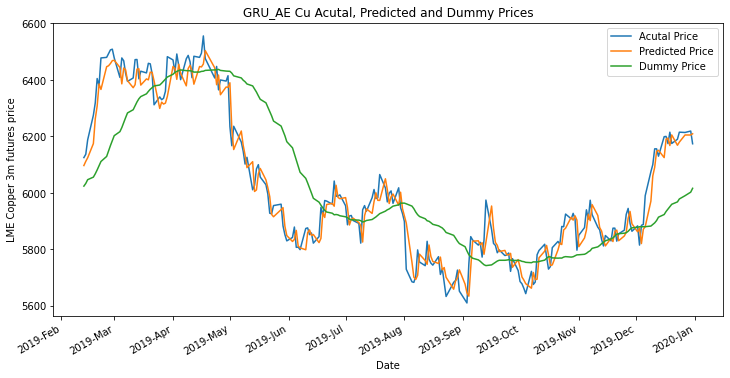

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

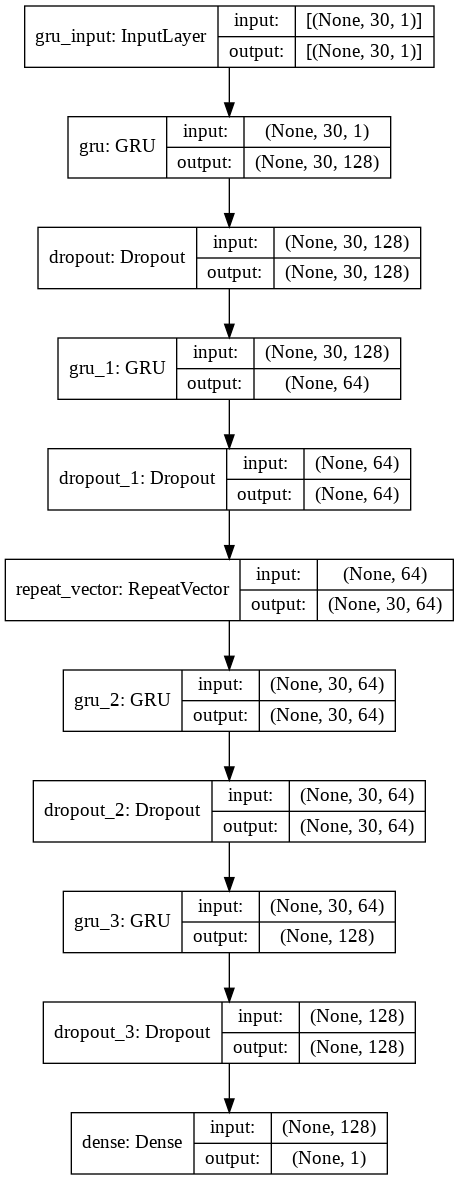

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0030078312153077697
RMSE:  0.05484369804551631
MAE:  0.043516439400307284
Dummy MSE:  0.02889885289047612
Dummy RMSE:  0.16999662611497945
Dummy MAE:  0.13217330779902475


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_AE_Cu/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_AE_Cu/assets
